## Car model classification
In order to automate car insurance claims' processing, it is sometimes required to be able to detect the car model from its pictures. In this exercise, we work on the Stanford Cars dataset in order to train a classification model to recognize car models. 
We will start by defining our dataloaders with the appropriate data processing and data augmentation steps, then we will train a model to classify car models, we will take the chance to interpret the results of the model then try to improve the training process to get better results.

### Install fastai (skip if already done)

In [ ]:
!pip install --upgrade fastai

### Import needed packages

In [1]:
import scipy.io
from fastbook import *
from fastai.vision.all import *

### Load the Cars dataset
The Stanford Cars dataset (https://ai.stanford.edu/~jkrause/cars/car_dataset.html) 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.
In FastAI, the dataset can be downloaded from the pre-built URLs. 

**Important note:** In the dataset that is loaded from FastAI, there is a discrepency between the image labels and reality. This discrepency is due to the fact that the FastAI dataset uses a collection of labels for both training and test dataset. In order to solve this issue, we download the training set labels from the Stanford Cars URL directly, which correspond to the labels of the training set without issues.

#### Load the Cars dataset from the pre-build URL
We download the Cars dataset from the pre-built URL in FastAI. This will allow us to retrieve the images.

In [2]:
path = untar_data(URLs.CARS) #TO DO
Path.BASE_PATH = path

In [3]:
path_to_annotations = path / 'cars_annos.mat'
annotations = scipy.io.loadmat(path_to_annotations)

In [4]:
annotations.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [5]:
annotations["annotations"].shape

(1, 16185)

In [6]:
classes = annotations['class_names']
classes.shape

(1, 196)

In [7]:
classes = [ c.item() for c in classes[0, :]]

#### Download the labels from the Stanford Cars website
We download the labels of the downloaded images from the official Cars website. The goal is to define a DataFrame that will be used to build the `ImageDataDataLoaders` object, which will be used to feed the model with data.

In [8]:
path_to_labels = 'https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz'
path_to_labels = untar_data(path_to_labels) #TO DO
path_to_labels.ls()

(#6) [Path('/home/azureuser/.fastai/data/car_devkit/cars_test_annos.mat'),Path('/home/azureuser/.fastai/data/car_devkit/README.txt'),Path('/home/azureuser/.fastai/data/car_devkit/train_perfect_preds.txt'),Path('/home/azureuser/.fastai/data/car_devkit/cars_meta.mat'),Path('/home/azureuser/.fastai/data/car_devkit/cars_train_annos.mat'),Path('/home/azureuser/.fastai/data/car_devkit/eval_train.m')]

In [9]:
path_to_labels

Path('/home/azureuser/.fastai/data/car_devkit')

In [10]:
annotations_train = scipy.io.loadmat(path_to_labels / 'cars_train_annos.mat') #TO DO

In [12]:
labels_train = annotations_train['annotations']
data_train = [(row[-1].item(), classes[row[-2].item() -1 ]) for row in labels_train[0,:]]
df_train = pd.DataFrame(data=data_train ,columns=['name', 'label'])

In [13]:
df_train.head()

,name,label
0,00001.jpg,Audi TTS Coupe 2012
1,00002.jpg,Acura TL Sedan 2012
2,00003.jpg,Dodge Dakota Club Cab 2007
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012


#### Limit the dataset to a few classes
The goal is to reduce the size of the training dataset and simplify the problem we are trying to solve. We are doing this for the sake of this exercise in order to limit the duration of training of the model.

In [14]:
sub_classes = ["Ford Focus Sedan 2007", "Chevrolet Camaro Convertible 2012",
               "Volkswagen Golf Hatchback 1991", "Lamborghini Diablo Coupe 2001",
               "BMW M3 Coupe 2012", "Dodge Ram Pickup 3500 Quad Cab 2009", "Land Rover Range Rover SUV 2012"]
df_train = df_train.loc[df_train["label"].isin(sub_classes)] # TO DO

In [15]:
df_train.shape

(313, 2)

#### Define the `ImageDataLoaders` object
In this section, we define the `ImageDataLoaders` object by calling `ImageDataLoaders.from_df(...)`. We define it as follows:

- validation percentage: 0.2
- batch size: 16 (the default value is 64, we will see together why it does not work for us later)
- item transforms: 
    - Resize to 512
    - Resize method: padding
    - Padding mode: zeros

In [16]:
item_tfms = [Resize(size=512, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)] #TO DO
dls = ImageDataLoaders.from_df(df_train, path, folder='cars_train', valid_pct=0.2, bs=16, valid_col=None, item_tfms=item_tfms) #TO DO

Let's display a batch of images using `show_batch` to check that everything is alright !
Hint: in order to display the image better, use the figure size paramater `figsize`

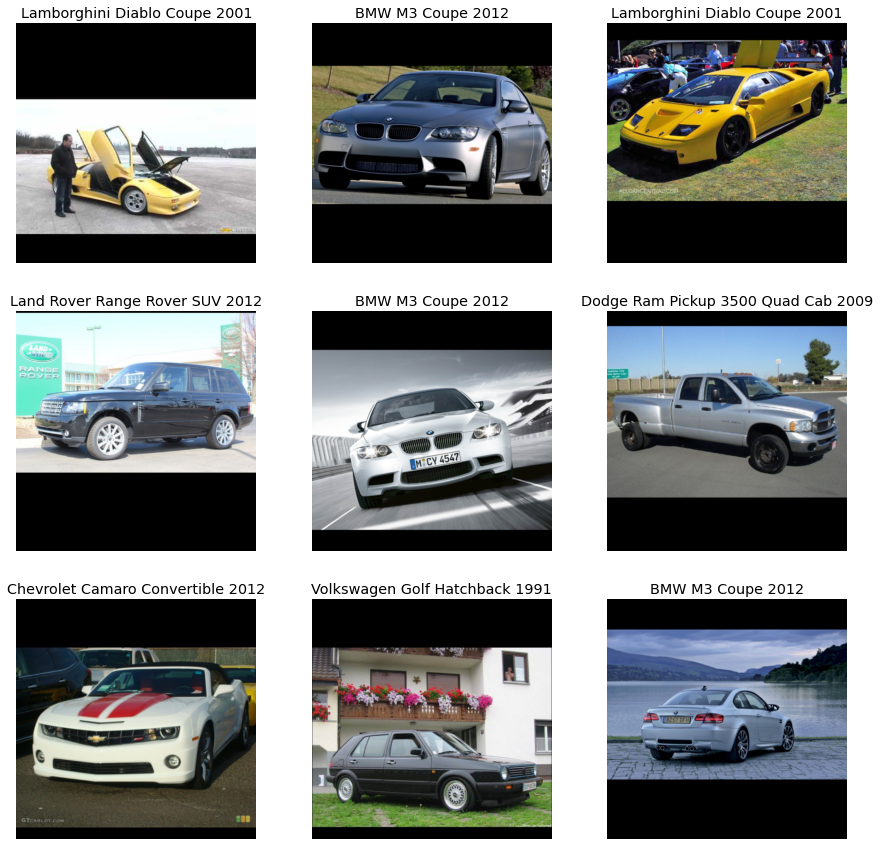

In [17]:
dls.show_batch(figsize=(15, 15))

### Train the model 
Let's define a pre-trained ResNet34 model and define accuracy as our metric of interest. Let's train the model for 5 epochs using `fine_tune()`

In [18]:
learn = cnn_learner(dls, resnet34, metrics=accuracy) #TO DO

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [19]:
learn.fine_tune(5) #TO DO

epoch,train_loss,valid_loss,accuracy,time
0,2.458849,0.892934,0.677419,00:19


epoch,train_loss,valid_loss,accuracy,time
0,0.947760,0.703029,0.806452,00:27
1,0.545890,0.411351,0.854839,00:27
2,0.353190,0.377797,0.887097,00:27
3,0.254010,0.291461,0.887097,00:27
4,0.187099,0.313932,0.887097,00:27


### Interpret the results of training
Let's use `ClassificationInterpretation` in order to interpret the results of the model.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn) #TO DO

Let's plot the confusion matrix of the model !

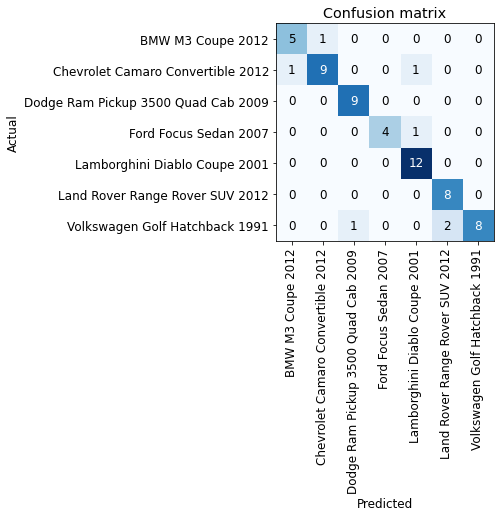

In [21]:
interp.plot_confusion_matrix() #TO DO

Now let's visualize the top losses to see which are due to misclassification

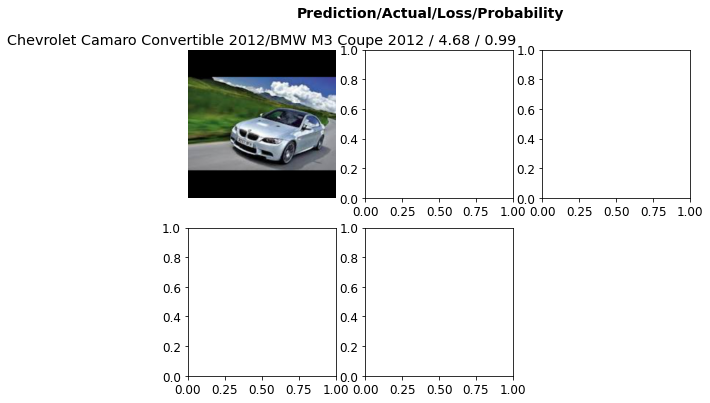

In [22]:
interp.plot_top_losses(5, nrows=2)

Let's now visualize which classes were confused with each other

In [23]:
interp.most_confused(min_val=1)

[('Volkswagen Golf Hatchback 1991', 'Land Rover Range Rover SUV 2012', 2),
 ('BMW M3 Coupe 2012', 'Chevrolet Camaro Convertible 2012', 1),
 ('Chevrolet Camaro Convertible 2012', 'BMW M3 Coupe 2012', 1),
 ('Chevrolet Camaro Convertible 2012', 'Lamborghini Diablo Coupe 2001', 1),
 ('Ford Focus Sedan 2007', 'Lamborghini Diablo Coupe 2001', 1),
 ('Volkswagen Golf Hatchback 1991', 'Dodge Ram Pickup 3500 Quad Cab 2009', 1)]

In [96]:
chevrolet_paths = [path/'cars_train'/img for img in df_train.loc[df_train["label"]=="Chevrolet Camaro Convertible 2012", "name"]]

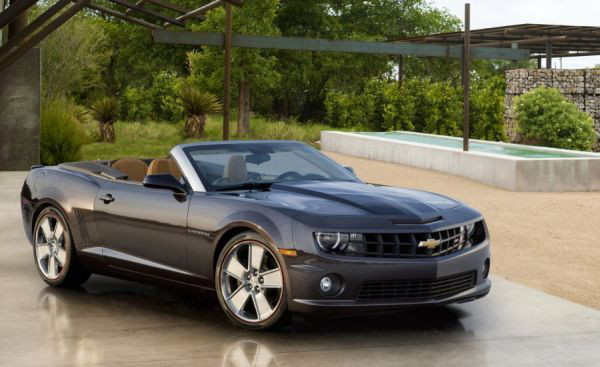

In [107]:
load_image(chevrolet_paths[3])

### Improving the model
We got a good start by fine tuning the pre-trained model. Let's try to improve our training strategy!
The first step, is using `fit_one_cycle()` with a given base learning rate. Before doing that, we try to find a good learning rate first by using `lr_find()`

In [24]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

SuggestedLRs(valley=0.0012022644514217973)

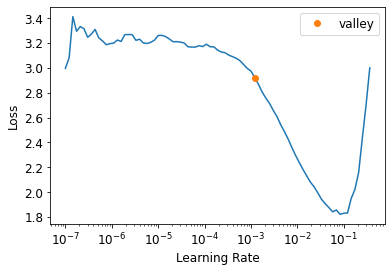

In [25]:
learn.lr_find()

Let's use `fit_one_cycle()` in order to fine tune the model for 3 epochs

In [28]:
learn.fit_one_cycle(3, lr_max=1e-3) #TO DO

epoch,train_loss,valid_loss,accuracy,time
0,2.733526,1.246344,0.532258,00:20
1,1.755572,0.557723,0.822581,00:19
2,1.273784,0.559764,0.790323,00:19


Let's unfreeze the model: when we use the pre-trained model, we only fine tune the final layers of the CNN, when we unfreeze the model, we allow all the weights of the model to be updated.

In [29]:
learn.unfreeze()

Let's find a new learning rate for our training because the old one is not usable anymore

SuggestedLRs(valley=0.00010964782268274575)

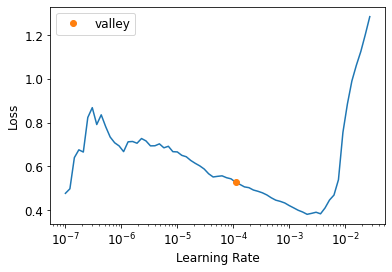

In [30]:
learn.lr_find()

Let's now train the model further for another 6 epochs

In [31]:
learn.fit_one_cycle(6, lr_max=1e-4) #TO DO

epoch,train_loss,valid_loss,accuracy,time
0,0.649141,0.488410,0.838710,00:27
1,0.431189,0.289475,0.919355,00:27
2,0.309691,0.216462,0.919355,00:27
3,0.231842,0.192654,0.951613,00:27
4,0.193739,0.207631,0.919355,00:27
5,0.163528,0.200799,0.919355,00:27


Now let's have a look at what loss values look like through epochs. Hint: use `learn.recorder`.

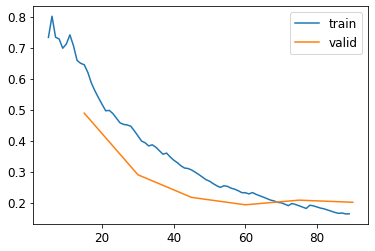

In [32]:
learn.recorder.plot_loss()

### Another (and perhaps better !) alternative
Another good alternative is to use `fine_tune` with the parameter `freeze_epochs` in order to train the model in a similar fashion to `lr_find` -> `fit_one_cycle` -> `unfreeze` -> `lr_find` -> `fit_one_cycle`.

In [33]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,3.037953,1.606412,0.387097,00:20
1,2.162583,0.569106,0.854839,00:20
2,1.496426,0.347561,0.919355,00:19


epoch,train_loss,valid_loss,accuracy,time
0,0.255508,0.289381,0.935484,00:27
1,0.208365,0.305043,0.919355,00:27
2,0.149007,0.272591,0.903226,00:27
3,0.112039,0.166962,0.951613,00:27
4,0.082980,0.161949,0.967742,00:27
5,0.072484,0.162416,0.967742,00:27


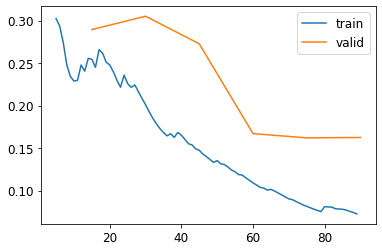

In [34]:
learn.recorder.plot_loss()

Let's have a second look at the confusion matrix and see how the model improved !

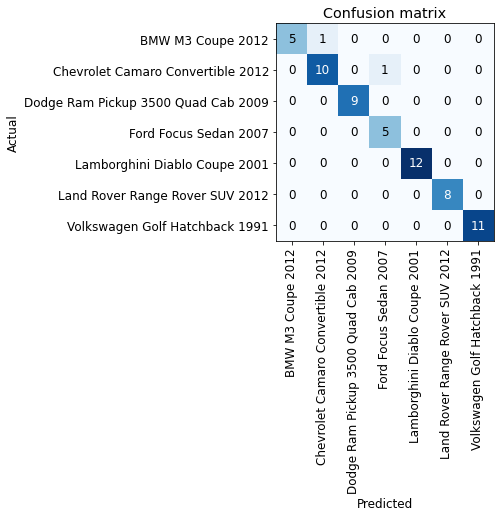

In [35]:
interp = ClassificationInterpretation.from_learner(learn) #TO DO
interp.plot_confusion_matrix() #TO DO